In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load the dataset
RNDSTATE = 42

ROOT_PATH = os.getcwd()
PATH = os.path.join(ROOT_PATH, "input", "creditcard.csv")

df = pd.read_csv(PATH, delimiter=",")

labels = df["Class"]
data = df[[c for c in df.columns if c != "Class"]]

In [3]:
# General info
def print_general_info(my_df, my_labels):
    unique_values, cnt = np.unique(my_labels, return_counts=True)
    if len(cnt) == 2:
        print("Nbr of geniune transactions (class=0): ", cnt[0])
        print("Nbr of fraudulent transactions (class=1): ", cnt[1])
        print("Input shape:", my_df.shape)
    else:
        print("Nbr of geniune transactions (class=0): ", cnt[0])
        print("Input shape:", my_df.shape)


In [4]:
# Full table info
print_general_info(df, labels)

Nbr of geniune transactions (class=0):  284315
Nbr of fraudulent transactions (class=1):  492
Input shape: (284807, 31)


In [5]:
# We split in 3 (training, validation and test set, where the training set contains only samples of the majority class)
X_testval_frau = data[labels == 1]
y_testval_frau = labels[labels == 1]

_X_train_gen = data[labels == 0]
_y_train_gen = labels[labels == 0]

X_train, X_testval_gen, y_train, y_testval_gen = train_test_split(
                                                _X_train_gen,
                                                _y_train_gen,
                                                test_size=0.2,
                                                random_state=RNDSTATE
                                                )

# add back the fraud trxn to the test/valid set
X_testval = pd.concat([X_testval_gen, X_testval_frau], ignore_index=True)
y_testval = pd.concat([y_testval_gen, y_testval_frau], ignore_index=True)

# Now we split the 20% from above in two (10% validation set, 10% test set). Note: they contain both classes (0, 1)
X_val, X_test, y_val, y_test = train_test_split(
                                            X_testval,
                                            y_testval,
                                            test_size=0.5,
                                            stratify=y_testval,
                                            random_state=RNDSTATE
                                            )

In [6]:
# Validation dataset general info
print_general_info(X_val, y_val)

Nbr of geniune transactions (class=0):  28431
Nbr of fraudulent transactions (class=1):  246
Input shape: (28677, 30)


In [7]:
# Test dataset general info
print_general_info(X_test, y_test)

Nbr of geniune transactions (class=0):  28432
Nbr of fraudulent transactions (class=1):  246
Input shape: (28678, 30)


In [8]:
# Training dataset general info
# Note: we only train on the background aka geniune transactions!
print_general_info(X_train, y_train)

Nbr of geniune transactions (class=0):  227452
Input shape: (227452, 30)


In [9]:
# Only two features are not scaled: Time and Amount
# Substract the mean and scale to unit variance
scaler_train = StandardScaler()
scaler_val = StandardScaler()
scaler_test = StandardScaler()

X_train["Time"] = scaler_train.fit_transform(X_train["Time"].values.reshape(-1,1))
X_train["Amount"] = scaler_train.fit_transform(X_train["Amount"].values.reshape(-1,1))
X_train = tf.cast(X_train.values, tf.float32)

X_val["Time"] = scaler_val.fit_transform(X_val["Time"].values.reshape(-1,1))
X_val["Amount"] = scaler_val.fit_transform(X_val["Amount"].values.reshape(-1,1))
X_val = tf.cast(X_val.values, tf.float32)

X_test["Time"] = scaler_test.fit_transform(X_test["Time"].values.reshape(-1,1))
X_test["Amount"] = scaler_test.fit_transform(X_test["Amount"].values.reshape(-1,1))
X_test = tf.cast(X_test.values, tf.float32)

In [10]:
# Autoencoder architecture
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(30, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(24, activation="relu"),
          layers.Dense(30, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AutoEncoder()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

# Model weights are saved at the end of every epoch, if it's the best seen so far
checkpoint_filepath = 'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

EPOCHS = 100
history = autoencoder.fit(
    X_train,
    X_train, 
    epochs=EPOCHS, 
    batch_size=512,
    validation_data=(X_val, X_val),
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

# We load the best weight into the model
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/100
445/445 [==============================] - 4s 8ms/step - loss: 0.6268 - val_loss: 0.6013
Epoch 2/100
445/445 [==============================] - 3s 7ms/step - loss: 0.5709 - val_loss: 0.5872
Epoch 3/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5623 - val_loss: 0.5790
Epoch 4/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5552 - val_loss: 0.5742
Epoch 5/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5507 - val_loss: 0.5694
Epoch 6/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5463 - val_loss: 0.5655
Epoch 7/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5428 - val_loss: 0.5621
Epoch 8/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5397 - val_loss: 0.5594
Epoch 9/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5371 - val_loss: 0.5561
Epoch 10/100
445/445 [==============================] - 3s 6ms/step - loss: 0.5335 - val_lo

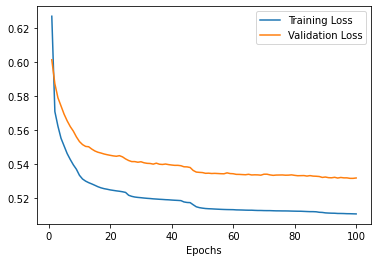

In [12]:
# Ploting the training/validation loss scores
xaxis = list(range(1, EPOCHS + 1))

plt.plot(xaxis, history.history["loss"], label="Training Loss")
plt.plot(xaxis, history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.legend()

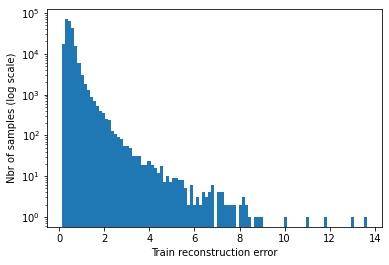

In [13]:
# Reconstruction error plot
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=100)
plt.xlabel("Train reconstruction error")
plt.ylabel("Nbr of samples (log scale)")
plt.yscale("log")
plt.show()

In [14]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.824996


In [15]:
# Reconstruction error on the test which contains geniune and fraudulent transaction
reconstruction_test = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstruction_test, X_test)

'''
If the reconstruction error is bigger than the threshold assign True else False.
In other words, if the error is smaller than the threshold it means that the AE was
able to reconstruct the input quite well and so can say that it is more likely a genuine transaction.
'''
y_pred = tf.math.less(threshold, test_loss)

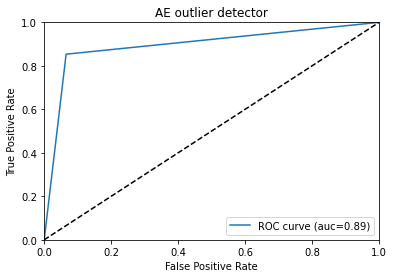

In [27]:
# Receiver Operating Characteristic Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC curve (auc=%0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AE outlier detector')
plt.legend(loc="best")
plt.savefig('AE_outlier_roc_curve.png', facecolor='lightgrey', bbox_inches='tight')

plt.show()

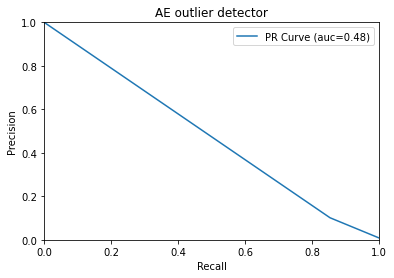

In [26]:
# Precision Recall Curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label='PR Curve (auc=%0.2f)' % auc(recall, precision))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AE outlier detector')
plt.legend(loc="best")
plt.savefig('AE_outlier_pr_curve.png', facecolor='lightgrey', bbox_inches='tight')

plt.show()